In [16]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy
import seaborn as sn
import matplotlib.pyplot as plt
from math import log
from collections import Counter

In [2]:
sub = ['control', 'test', 'difference', 'bca_low', 'bca_high']
data = pd.read_csv('/Users/Emily/Documents/S1/S1_3.csv', usecols=sub).reset_index(drop=True)

In [3]:
def CItoP(row):
    u = row['bca_high']
    l = row['bca_low']
    Est = row['difference']
    #calculate the standard error from the upper and lower bounds of the confidence interval
    SE = (u-l)/(2*1.96)
    #calculate the z-score from the difference in means (estimated mean) over the standard error
    z = Est/SE
    #find the area under the curve of the CDF for the associated z-score using scipy.stats.special.ndtr or scipy.stats.norm.sf
    #equations to integrate the area under the curve for both functions are the same.
    p = norm.sf(abs(z))*2 #two-sided
    return p

In [4]:

for index, row in data.iterrows():
    data.loc[index, 'p_value'] = CItoP(row)


In [5]:
# i = pvalue rank
# m = total number of tests
# Q = false discovery rate percentage

def BH_critical(i, m, Q):
    correction = (i/m)*Q
    return correction

In [6]:
def pranks(df, fdr):
    hed = 'BH_critical_' + str(fdr)
    for index, row in df.iterrows():
        df.loc[index, hed] = BH_critical(row['rank'],96,fdr)
    return df

In [7]:
vals96 = pd.DataFrame()
controls = ['DMSO', 'H2O']

for c in controls:
    h = data.loc[data['control']==c]
    ranked = h.sort_values(by=['p_value']).reset_index(drop=True)
    ranks=np.arange(1,len(ranked)+1)
    ranked['rank'] = ranks
    BH = pranks(ranked, .05)
    vals96 = vals96.append(BH)
vals96.tail()

,control,test,difference,bca_low,bca_high,p_value,rank,BH_critical_0.05
90,H2O,Eucalyptol,0.131015,-1.520330,1.710998,0.873718,91,0.047396
91,H2O,Carnosic acid,0.116052,-1.502566,1.752305,0.888844,92,0.047917
92,H2O,Rosmarinic acid,-0.100297,-1.653787,1.484949,0.900316,93,0.048438
93,H2O,Trans-Anethole,-0.072106,-1.680317,1.456152,0.928192,94,0.048958
94,H2O,Skatole,0.017496,-1.500906,1.571867,0.982193,95,0.049479


In [8]:
filtered_BH = vals96.loc[vals96['p_value'] < vals96['BH_critical_0.05']]
filtered_BH

,control,test,difference,bca_low,bca_high,p_value,rank,BH_critical_0.05
0,DMSO,Isoamyl alcohol,14.166999,12.820407,15.511796,1.353903e-94,1,0.000521
1,DMSO,2-Methyl-1-butanol,11.712247,9.891178,13.409462,6.392657e-39,2,0.001042
2,DMSO,Thiophene,9.759898,8.202217,11.263300,7.612012e-36,3,0.001563
3,DMSO,"2,3-Dihydrobenzofuran",9.194467,7.629789,10.673937,2.428362e-32,4,0.002083
4,DMSO,Diacetyl,8.018781,6.589946,9.361027,7.992905e-30,5,0.002604
...,...,...,...,...,...,...,...,...
35,H2O,Oleanolic Acid,-2.178525,-3.833409,-0.583985,8.586267e-03,36,0.018750
36,H2O,Ethyl palmitate,2.155766,0.531007,3.781640,9.331073e-03,37,0.019271
37,H2O,Piperonyl Alcohol,1.872080,0.430105,3.296847,1.047040e-02,38,0.019792
38,H2O,p-Tolualdehyde,1.987114,0.397433,3.483390,1.159710e-02,39,0.020313


In [9]:
#filtered_BH.to_csv('/Users/Emily/Desktop/ReviewerResponses/filteredBH_.05.csv')
#vals96.to_csv('/Users/Emily/Desktop/ReviewerResponses/96_CItoPvals_.3.csv')

In [18]:
#Comparing the "significant" hits between DMSO and H2O controls. What compounds are found in both sets?
test = filtered_BH['test']
counts = Counter(test)
output = [value for value, count in counts.items() if count > 1]

39


In [28]:
#Next we want to find which compounds we would have omitted from our mutant screens if we had performed BH-corrections
followups = pd.read_csv('/Users/Emily/Documents/S1/inner3.csv', index_col=0)
comps = list(followups['test'].unique())
set1 = set(comps)
set2 = set(output)
missing = list(sorted(set1 - set2))
missing

['DMSO', 'H2O', 'Oleanolic Acid', 'Sabinene', 'Sinomenine hydrochloride']

['Isoamyl alcohol',
 '2-Methyl-1-butanol',
 'Thiophene',
 '2,3-Dihydrobenzofuran',
 'Diacetyl',
 '1-octanol',
 'Phytol',
 'Phenylacetylene',
 '2-nonanone',
 'α-Phellandrene',
 'Acetophenone',
 'Coumaran',
 'Ellagic acid',
 'Paeoniflorin',
 'Guaiazulene',
 'L-Mimosine',
 'Leonurine',
 'Salvinorin A Propionate',
 'Solasodine',
 'Isoquinoline',
 'Spinosad',
 'Camphor',
 'Furfural',
 '(-)-Huperzine A',
 'Ursolic acid',
 'Safranal',
 'Anisole',
 'Methyl palmitate',
 'Limonin',
 'Cinnamyl Alcohol',
 'Piperitenone',
 'Ethyl p-methoxycinnamate',
 'Daucosterol',
 '2,5-Dihydroxybenzoic acid',
 'Carnosol',
 'Oleanolic Acid',
 'Ethyl palmitate',
 'Piperonyl Alcohol',
 'p-Tolualdehyde',
 'Lapachol']

In [141]:
cols = ['control', 'test', 'difference', 'bca_low', 'bca_high', 'Strain']
mut_data = pd.read_csv('/Users/Emily/Documents/S1F2/all_strains_mdiff_dmso.csv', usecols=cols, index_col=0).reset_index(drop=True)
#mut_data=mut_data.rename(columns={"index": "rank"})
mut_data.head()

,test,difference,bca_low,bca_high,Strain
0,(-)-Huperzine A,2.506552,1.196282,3.777346,PR678
1,1-octanol,-3.953032,-5.293354,-2.707069,PR678
2,"2,3-Dihydrobenzofuran",6.791056,5.381876,8.232949,PR678
3,"2,5-Dihydroxybenzoic acid",1.256955,0.014839,2.370033,PR678
4,2-Methyl-1-butanol,1.722631,0.324622,3.058874,PR678


In [142]:
for index, row in mut_data.iterrows():
    mut_data.loc[index, 'p_value'] = CItoP(row)
mut_data.head()


,test,difference,bca_low,bca_high,Strain,p_value
0,(-)-Huperzine A,2.506552,1.196282,3.777346,PR678,1.407567e-04
1,1-octanol,-3.953032,-5.293354,-2.707069,PR678,2.078376e-09
2,"2,3-Dihydrobenzofuran",6.791056,5.381876,8.232949,PR678,9.894877e-21
3,"2,5-Dihydroxybenzoic acid",1.256955,0.014839,2.370033,PR678,3.643103e-02
4,2-Methyl-1-butanol,1.722631,0.324622,3.058874,PR678,1.352355e-02


In [173]:
FDR=.05
all_vals = pd.DataFrame()

muts = ['N2', 'CX10', 'PR678', 'GN1077']
for m in muts:
    h = mut_data.loc[mut_data['Strain']==m]
    ranked_mut = h.sort_values(by=['p_value']).reset_index(drop=True)
    ranks=np.arange(1,len(ranked_mut)+1)
    ranked_mut['rank'] = ranks
    BH = pranks(ranked_mut, FDR)
    all_vals = all_vals.append(BH)
all_vals.tail()

,test,difference,bca_low,bca_high,Strain,p_value,rank,BH_critical_0.05
37,Limonin,-0.283288,-1.295399,0.713166,GN1077,0.580347,38,0.045238
38,Leonurine,-0.247556,-1.238923,0.690922,GN1077,0.615071,39,0.046429
39,Camphor,-0.214094,-1.215805,0.732332,GN1077,0.666617,40,0.047619
40,L-Mimosine,0.141006,-0.777214,1.025659,GN1077,0.759155,41,0.048810
41,1-octanol,-0.040677,-0.936400,0.852508,GN1077,0.928974,42,0.050000


In [174]:
all_vals.to_csv('/Users/Emily/Desktop/ReviewerResponses/mutants_CItoPvals_' + str(fdr) +'.csv')

In [175]:
x = np.arange(1, 42)
y = BH_critical(x, 42, FDR)

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

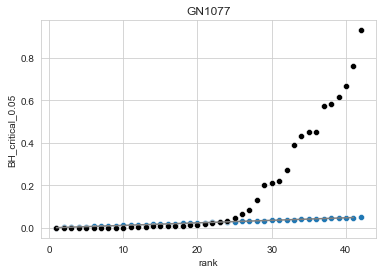

In [191]:
def quick_plot(strain, x, y):

    df = all_vals.loc[all_vals['Strain']==strain]

    sn.set_style('whitegrid')
    sn.scatterplot(df['rank'],df['BH_critical_0.05'])
    sn.scatterplot(df['rank'], df['p_value'], color = 'black')
    sn.lineplot(x, y, color='gray')
    plt.title(strain)

    plt.savefig('/Users/Emily/Desktop/ReviewerResponses/BHcritical_.05.png')
quick_plot('GN1077', x, y)

In [177]:
s_subs=['control', 'test', 'difference', 'bca_low', 'bca_high','Compound']
btwn_strns = pd.read_csv('/Users/Emily/Documents/S1F2/N2vMuts_mdiff_dmso.csv', usecols=s_subs).reset_index(drop=True)


In [178]:
for index, row in btwn_strns.iterrows():
    btwn_strns.loc[index, 'p_value'] = CItoP(row)

In [179]:
btwn_strns.head()

,control,test,difference,bca_low,bca_high,Compound,p_value
0,N2,PR678,-1.241810,-2.549919,0.106607,DMSO,0.066888
1,N2,PR678,-2.113225,-3.508475,-0.685667,(-)-Huperzine A,0.003340
2,N2,PR678,2.251417,0.773548,3.672143,1-octanol,0.002329
3,N2,PR678,-3.645221,-5.272238,-2.014324,"2,3-Dihydrobenzofuran",0.000012
4,N2,PR678,-2.447849,-3.730321,-1.095766,"2,5-Dihydroxybenzoic acid",0.000270


In [181]:
btwnstrn_vals = pd.DataFrame()
for m in muts:
    hold = btwn_strns.loc[btwn_strns['test']==m]
    ranked_mut = hold.sort_values(by=['p_value']).reset_index(drop=True)
    ranks=np.arange(1,len(ranked_mut)+1)
    ranked_mut['rank'] = ranks
    BH = pranks(ranked_mut, .05)
    btwnstrn_vals = btwnstrn_vals.append(BH)
btwnstrn_vals.tail()

,control,test,difference,bca_low,bca_high,Compound,p_value,rank,BH_critical_0.05
38,N2,GN1077,1.637926,0.390031,2.855765,Methyl palmitate,0.009215,39,0.046429
39,N2,GN1077,1.611459,0.302432,2.924567,Ursolic acid,0.015993,40,0.047619
40,N2,GN1077,-1.658267,-3.026030,-0.156698,Solasodine,0.023483,41,0.048810
41,N2,GN1077,0.903014,-0.269220,2.063606,DMSO,0.129167,42,0.050000
42,N2,GN1077,-0.682615,-1.962065,0.553088,H2O,0.287378,43,0.051190


In [86]:
btwnstrn_vals.to_csv('/Users/Emily/Desktop/ReviewerResponses/btwnstrns_CItoPvals.csv')